In [1]:
#STUDENT DETAILS

# FULL NAME: SHIVANGI GUPTA
# USC ID:8972835473

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as sf
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import preprocessing
from beautifultable import BeautifulTable
from scipy.spatial import distance

In [3]:
# function to count rows and columns
def describe_data():
    row_count=ccpp_data.shape[0]
    print("Total Number of Rows are : ",str(row_count))
    column_count=ccpp_data.shape[1]
    print("Total Number of Columns are : ",str(column_count))
    print("Rows represent observations/instances collected over 6 years from a combined cycle power plant")
    print("Columns represent the features and response for each observation collected")

In [4]:
# function to draw scatter plot for all variables
def draw_scatter_plot():
    sb.pairplot(ccpp_data,kind='scatter',plot_kws={"s":8},markers="+")
    print("The relationship between AT & PE looks linear and for (V & PE) and (AT & V),it looks somewhat linear but for other pairs the data points are scattered(somewhat non-linear).So linear regression model is best fit for AT vs PE ,and somewhat better for (V & PE) and (AT & V) and bad fit for others")

In [5]:
# function to calculate mean,median,Q1,Q3,IQR and range
def data_stats():
    mean_data=pd.Series.to_frame(ccpp_data.mean(axis=0)).T
    median_data=pd.Series.to_frame(ccpp_data.median(axis=0)).T
    range_data=pd.Series.to_frame(ccpp_data.max()-ccpp_data.min()).T
    q1_data=pd.Series.to_frame(ccpp_data.quantile(.25,axis=0)).T
    q3_data=pd.Series.to_frame(ccpp_data.quantile(.75,axis=0)).T
    iqr_data=pd.Series.to_frame((ccpp_data.quantile(.75,axis=0)).subtract(ccpp_data.quantile(.25,axis=0))).T
    result=pd.concat([mean_data,median_data,range_data,q1_data,q3_data,iqr_data],ignore_index="True")
    result.rename(index = {0: "MEAN", 1:"MEDIAN",2:"RANGE",3:"FIRST QUARTILE", 4:"THIRD QUARTILE",5:"INTER QUARTILE RANGE"}, inplace = True)
    return result

In [6]:
# Show data in a table(present data in tabular form)
def showData(headers, rows):
    bTable = BeautifulTable(max_width=120)
    bTable.set_style(BeautifulTable.STYLE_SEPARATED)
    bTable.column_headers = headers
    for i in range(0, len(rows)):
        bTable.append_row(rows[i])
    print(bTable)

In [7]:
# making table data
def make_data(name,parameters,std_error,tvalues,pvalues):
    rowData=[]
    for j in range(0,len(parameters)):
        temp=[]
        temp.append(name[j])
        temp.append(parameters[j])
        temp.append(std_error[j])
        temp.append(tvalues[j])
        temp.append(pvalues[j])
        if(pvalues[j]>0.05):
            temp.append("Statistically Insignificant Parameter")
        else:
            temp.append("Statistically Significant Parameter")
        rowData.append(temp)
    return rowData

In [8]:
# function to draw residual plot and remove outliers 
def draw_outlier(residuals,predictions):
    plt.scatter(predictions,residuals,s=0.5,color="blue")
    plt.xlabel("Fitted Values")
    plt.ylabel("Studentized Residuals")
    plt.title("Residual Plot")
    plt.show()
    index=[]
    for i in range(0,len(residuals)):
        if(abs(residuals[i])>3):
            index.append(i)
    return index
            

In [9]:
# Linear regression for each predicor and response
def linear_regression(predictors,target):
    linear_params=[]
    for i in predictors.columns:
        X=ccpp_data[i]
        X = sm.add_constant(X)
        model = sm.OLS(target,X).fit()
        predictions = model.predict(X) 
        influence = model.get_influence()
        studentized_residuals = influence.resid_studentized_external
        #print(model.summary())
        parameters,std_error,tvalues,pvalues,rsquared=model.params,model.bse,model.tvalues,model.pvalues,model.rsquared
        name=pd.DataFrame(parameters).index.tolist()
        rowData=make_data(name,parameters,std_error,tvalues,pvalues)
        print("Summary before removing outliers for "+ str(i))
        showData(Headings,rowData)
        print("R Square(R2) value for the above model is : "+str(rsquared))
        z=pd.DataFrame(model.params)
        linear_params.append(z[0][1])
        plt.scatter(ccpp_data[i],ccpp_data["PE"],s=0.5,color="blue",label="")
        plt.plot(ccpp_data[i],predictions,color="red",label=('PE=({:.2f})+({:.2f})'.format(z[0][0],z[0][1]))+str(i))
        plt.xlabel(i)
        plt.ylabel("PE")
        plt.legend()
        plt.title("Plot with outliers")
        plt.show()
        index=draw_outlier(studentized_residuals,predictions)
        X_out=pd.DataFrame(X).iloc[:,1:]
        new_target=np.delete(np.array(target),index)
        new_X=np.delete(np.array(X_out),index)
        train_X=sm.add_constant(new_X)
        model1 = sm.OLS(new_target,train_X).fit()
        prediction_after_outliers=model1.predict(train_X);
        #print(model1.summary())
        name=["const"]
        parameters,std_error,tvalues,pvalues,rsquared=model1.params,model1.bse,model1.tvalues,model1.pvalues,model1.rsquared
        name.append(i)
        rowData=make_data(name,parameters,std_error,tvalues,pvalues)
        print("Summary after removing outliers for "+ str(i))
        showData(Headings,rowData)
        print("R Square(R2) value for the above model is : "+str(rsquared))
        plt.scatter(np.ravel(new_X),np.ravel(new_target),s=0.5,color="blue",label="")
        plt.plot(np.ravel(new_X),prediction_after_outliers,color="red",label=('PE=({:.2f})+({:.2f})'.format(parameters[0],parameters[1]))+str(i))
        plt.xlabel(i)
        plt.ylabel("PE")
        plt.title("Plot without outliers")
        plt.legend()
        plt.show()
    return linear_params

In [10]:
# multiple regression using all predictors
def multiple_regression(target,predictors):
    multi_params=[]
    x=predictors
    predictors = sm.add_constant(predictors)
    model = sm.OLS(target,predictors).fit() 
    pred_train=model.predict(predictors)
    z=pd.DataFrame(model.params)
    znew=z.T
    for i in predictors.columns:
        multi_params.append(znew[i][0])
    multi_params=multi_params[1:]
    parameters,std_error,tvalues,pvalues,rsquared=model.params,model.bse,model.tvalues,model.pvalues,model.rsquared
    name=pd.DataFrame(parameters).index.tolist()
    rowData=make_data(name,parameters,std_error,tvalues,pvalues)
    showData(Headings,rowData)
    print("R Square(R2) for multiple regression is : "+str(rsquared))
    return multi_params

In [11]:
#cofficients comparison between multiple regression and linear regression with each predictor
def comparison_linear_multiple_coefficients(linear_params,multi_params):
    predictors=ccpp_data.iloc[:,0:4]
    color=['red','green','blue','black']
    for i in range(0,4):
        plt.scatter(linear_params[i],multi_params[i],color=color[i],label=predictors.columns[i])
        plt.xlabel("Linear Regression coefficients")
        plt.ylabel("Multiple Regression coefficients")
    plt.legend()
    plt.show()

In [12]:
#function doing regression with non linear terms
def non_linear_model():
    target=ccpp_data["PE"]
    predictors=ccpp_data.iloc[:,0:4]
    for i in predictors.columns:
        print("Non Linear Association for "+str(i))
        f1='PE ~ '+'I('+str(i)+'**1)+'+'I('+str(i)+'**2)+'+'I('+str(i)+'**3)'
        model = sm.OLS.from_formula(formula = f1,data=ccpp_data).fit()
        #print(model.summary())
        parameters,std_error,tvalues,pvalues,rsquared=model.params,model.bse,model.tvalues,model.pvalues,model.rsquared
        name=pd.DataFrame(parameters).index.tolist()
        rowData=make_data(name,parameters,std_error,tvalues,pvalues)
        showData(Headings,rowData)
        print("R Square(R2) for multiple regression is : "+str(rsquared))
        

In [13]:
#function doing regression with interaction terms
def regression_interaction_terms():
    predictors=ccpp_data.iloc[:,0:4]
    x_t = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(predictors)
    target=ccpp_data["PE"]
    predictors=pd.DataFrame(x_t)
    predictors.columns = ['AT', 'V', 'AP', 'RH', 'AT*V','AT*AP','AT*RH','V*AP','V*RH','AP*RH']
    predictors = sm.add_constant(predictors)
    model = sm.OLS(target,predictors).fit()
    predictions = model.predict(predictors) 
    #print(model.summary())
    parameters,std_error,tvalues,pvalues,rsquared=model.params,model.bse,model.tvalues,model.pvalues,model.rsquared
    name=pd.DataFrame(parameters).index.tolist()
    rowData=make_data(name,parameters,std_error,tvalues,pvalues)
    for i in range(0,5):
        rowData[i][5]=" "
    showData(Headings,rowData)
    print("R Square(R2) for multiple regression is : "+str(rsquared))

In [14]:
#compare models one with all terms and other with only significant terms
def comparison_two_models():
    res=[]
    X_train, X_test, y_train, y_test = train_test_split(ccpp_data.iloc[:,0:4], target,test_size=0.3)
    predictors=ccpp_data.iloc[:,0:4]
    f1='PE ~ '
    for i in predictors.columns:
        f1=f1+'I('+str(i)+'**2)+'
    for i in range(0,3):
        for j in range(i+1,4):
            a=predictors.columns[i]
            b=predictors.columns[j]
            f1=f1+str(a)+'*'+str(b)+'+'
    f1=f1[:-1]
    x=pd.DataFrame(X_train)
    y=pd.DataFrame(y_train)
    train_ccpp_data=x.join(y)
    model = sm.OLS.from_formula(formula = f1,data=train_ccpp_data).fit()
    #print(model.summary())
    pred_test=model.predict(X_test)
    pred_train=model.predict(X_train)
    trerror=np.mean((y_train-np.ravel(pred_train))**2)
    teerror=np.mean((y_test-np.ravel(pred_test))**2)
    res.append(round(teerror,2))
    parameters,std_error,tvalues,pvalues,rsquared=model.params,model.bse,model.tvalues,model.pvalues,model.rsquared
    name=pd.DataFrame(parameters).index.tolist()
    rowData=make_data(name,parameters,std_error,tvalues,pvalues)
    significant_terms=[]
    for i in range(0,len(rowData)):
        if(rowData[i][5]=="Statistically Significant Parameter" and len(rowData[i][0])>2 and (rowData[i][0]!="const" and rowData[i][0]!="Intercept")):
            significant_terms.append(rowData[i][0]);
    print(" ")
    print("FULL MODEL WITH ALL TERMS")
    showData(Headings,rowData)
    print("Train MSE with all terms(interaction and non linear) : "+str(round(trerror,2)))
    print("Test MSE with all terms(interaction and non linear) : "+str(round(teerror,2)))

    f2="PE~"
    for i in significant_terms:
        i=str(i).replace(":", "*")
        if(i[-1:]=="2"):
            f2=f2+"I("+str(i)+")+"
        else:
            f2=f2+str(i)+"+"
    f2=f2[:-1]
    model = sm.OLS.from_formula(formula = f2,data=train_ccpp_data).fit()
    pred_test=model.predict(X_test)
    pred_train=model.predict(X_train)
    trerror=np.mean((y_train-np.ravel(pred_train))**2)
    teerror=np.mean((y_test-np.ravel(pred_test))**2)
    parameters,std_error,tvalues,pvalues,rsquared=model.params,model.bse,model.tvalues,model.pvalues,model.rsquared
    name=pd.DataFrame(parameters).index.tolist()
    rowData=make_data(name,parameters,std_error,tvalues,pvalues)
    print("MODEL AFTER REMOVING INSIGNIFICANT TERMS")
    showData(Headings,rowData)
    #print(model.summary())
    print("Train MSE with all significant terms : "+str(round(trerror,2)))
    print("Test MSE with all significant terms : "+str(round(teerror,2)))
    res.append(round(teerror,2))
    return res

In [15]:
# knn regression with raw feautures
def knn_regression_raw_features():
    X_train, X_test, y_train, y_test = train_test_split(ccpp_data.iloc[:,0:4], target, test_size=0.3)
    test_error=[]
    train_error=[]
    for k in range(1,101,1):
        regressor = KNeighborsRegressor(n_neighbors=k)  
        regressor.fit(X_train, y_train) 
        y_pred = regressor.predict(X_test) 
        y_pred1 = regressor.predict(X_train) 
        test_error.append(np.mean((y_pred-y_test)**2))
        train_error.append(np.mean((y_pred1-y_train)**2))

    k_value=[]
    for i in range(1,101):
        k_value.append(1/i)
    plt.plot(k_value,test_error,color="blue",label="Test Error")
    plt.plot(k_value,train_error,color="red",label="Train Error")
    plt.xlabel("1/k")
    plt.ylabel("MSE")
    plt.title("MSE PLOT(RAW DATA)")
    plt.legend()
    plt.show()
    print("VALUE OF K FOR THE BEST FIT WITH RAW FEAUTURES IS : "+str(test_error.index(min(test_error))+1))
    print("Smallest Test Error is : "+str(min(test_error)))
    return min(test_error)

In [16]:
#knn regression with normalize features
def knn_regression_normalize_features():
    test_error=[]
    train_error=[]
    min_max_scaler = preprocessing.MinMaxScaler()
    ccpp_norm = min_max_scaler.fit_transform(ccpp_data.iloc[:,0:4])
    ccpp_normalized = pd.DataFrame(ccpp_norm)
    X_train, X_test, y_train, y_test = train_test_split(ccpp_normalized.iloc[:,0:4], target, test_size=0.3)
    for k in range(1,101,1):
        regressor = KNeighborsRegressor(n_neighbors=k)  
        regressor.fit(X_train, y_train) 
        y_pred = regressor.predict(X_test) 
        y_pred1 = regressor.predict(X_train) 
        test_error.append(np.mean((y_pred-y_test)**2))
        train_error.append(np.mean((y_pred1-y_train)**2))

    k_value=[]
    for i in range(1,101):
        k_value.append(1/i)
    plt.plot(k_value,test_error,color="blue",label="Test Error")
    plt.plot(k_value,train_error,color="red",label="Train Error")
    plt.xlabel("1/k")
    plt.ylabel("MSE")
    plt.title("MSE PLOT(NORMALIZE DATA)")
    plt.legend()
    plt.show()
    print("VALUE OF K FOR THE BEST FIT WITH NORMALIZED FEATURES IS : "+str(test_error.index(min(test_error))+1))
    print("Smallest Test Error is : "+str(min(test_error)))
    return min(test_error)

In [17]:
def knn_classifier(k):
    tr={"X1":[0,2,0,0,-1,1],"X2":[3,0,1,1,0,1],"X3":[0,0,3,2,1,1],"Y":["Red","Red","Red","Green","Green","Red"]}
    fg=pd.DataFrame(tr)
    classifier = KNeighborsClassifier(n_neighbors=k)  
    classifier.fit(fg.iloc[:,0:3], np.ravel(fg.iloc[:,3:])) 
    te=pd.DataFrame({"X1":[0],"X2":[0],"X3":[0]})
    y_pred = classifier.predict(te)
    return y_pred[0]


In [18]:
#1a
Headings=["Names","Coefficients","Standard Error","t-statistic","p-value","Results"]
ccpp_data=pd.read_excel("https://raw.githubusercontent.com/71sgupta/HW2_ML/master/Folds5x2_pp.xlsx",sheet_name="Sheet1")
target=ccpp_data["PE"]
predictors=ccpp_data.iloc[:,0:4]

In [19]:
#1b(i)
describe_data()

Total Number of Rows are :  9568
Total Number of Columns are :  5
Rows represent observations/instances collected over 6 years from a combined cycle power plant
Columns represent the features and response for each observation collected


The relationship between AT & PE looks linear and for (V & PE) and (AT & V),it looks somewhat linear but for other pairs the data points are scattered(somewhat non-linear).So linear regression model is best fit for AT vs PE ,and somewhat better for (V & PE) and (AT & V) and bad fit for others


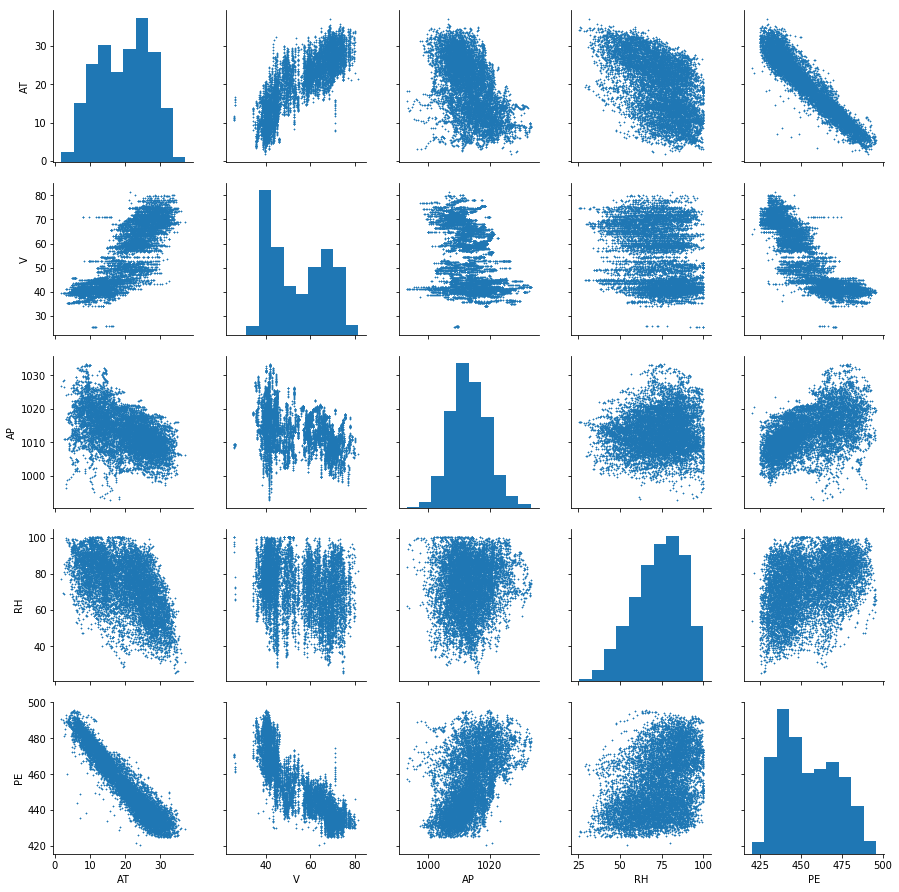

In [20]:
#1b(ii)
draw_scatter_plot()

In [21]:
#1b(iii)
data_stats()

,AT,V,AP,RH,PE
MEAN,19.651231,54.305804,1013.259078,73.308978,454.365009
MEDIAN,20.345000,52.080000,1012.940000,74.975000,451.550000
RANGE,35.300000,56.200000,40.410000,74.600000,75.500000
FIRST QUARTILE,13.510000,41.740000,1009.100000,63.327500,439.750000
THIRD QUARTILE,25.720000,66.540000,1017.260000,84.830000,468.430000
INTER QUARTILE RANGE,12.210000,24.800000,8.160000,21.502500,28.680000


f:\software\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Summary before removing outliers for AT
+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |   497.034    |     0.156      |   3177.28   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|  AT   |    -2.171    |     0.007      |  -291.715   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
R Square(R2) value for the above model is : 0.8989475964148236


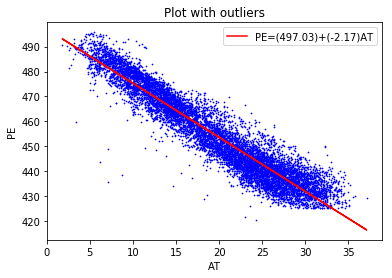

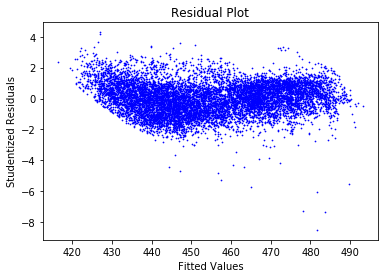

Summary after removing outliers for AT
+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |   497.229    |     0.151      |  3294.842   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|  AT   |    -2.18     |     0.007      |  -303.652   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
R Square(R2) value for the above model is : 0.9063781131824249


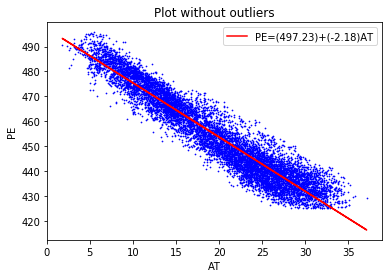

Summary before removing outliers for V
+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |   517.802    |     0.378      |  1370.218   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|   V   |    -1.168    |     0.007      |  -172.402   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
R Square(R2) value for the above model is : 0.7565177870683977


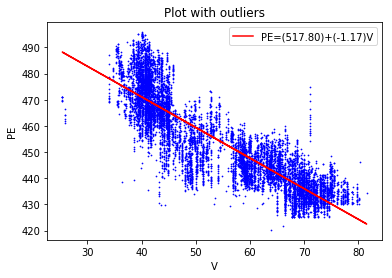

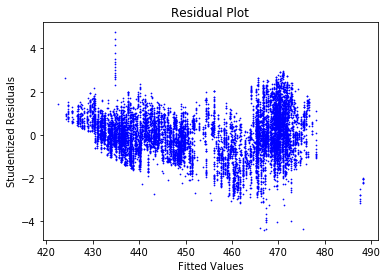

Summary after removing outliers for V
+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |   518.323    |     0.371      |  1398.518   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|   V   |    -1.177    |     0.007      |  -177.142   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
R Square(R2) value for the above model is : 0.7669898384242


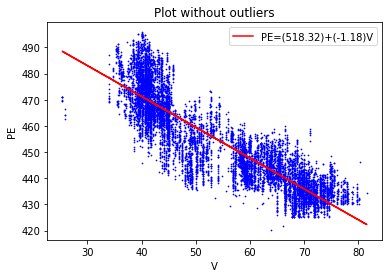

Summary before removing outliers for AP
+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |  -1055.261   |     25.459     |   -41.449   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|  AP   |     1.49     |     0.025      |   59.296    |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
R Square(R2) value for the above model is : 0.2687686564110666


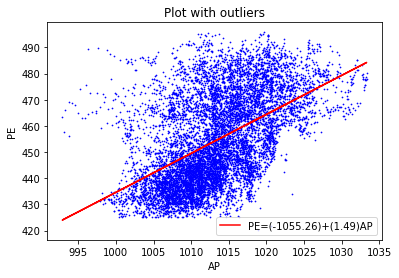

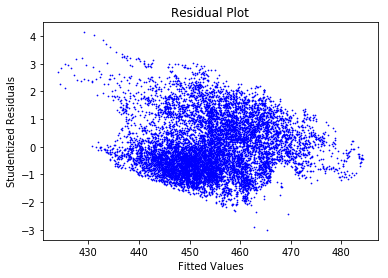

Summary after removing outliers for AP
+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |  -1106.262   |     25.224     |   -43.858   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|  AP   |     1.54     |     0.025      |   61.869    |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
R Square(R2) value for the above model is : 0.2864283159595904


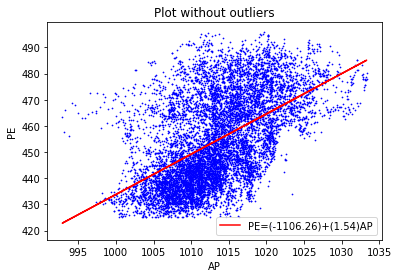

Summary before removing outliers for RH
+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |   420.962    |     0.823      |   511.676   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|  RH   |    0.456     |     0.011      |   41.399    |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
R Square(R2) value for the above model is : 0.151939440231175


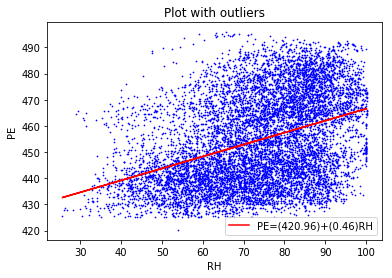

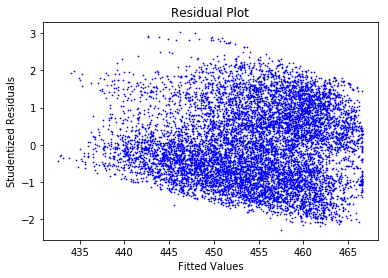

Summary after removing outliers for RH
+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |   420.897    |     0.822      |   511.944   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|  RH   |    0.456     |     0.011      |   41.497    |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
R Square(R2) value for the above model is : 0.1525764206861554


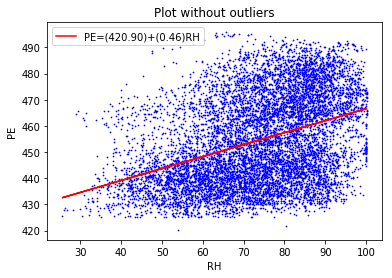

ALl models have statistically significant association as shown in the results in above table
R squared value are near to 1 for AT and V but for AP and RH the values are very less so AT and V show better linear behaviour with response PE than AP and RH


In [22]:
#1c
target=ccpp_data["PE"]
predictors=ccpp_data.iloc[:,0:4]
linear_params=linear_regression(predictors,target)
print("ALl models have statistically significant association as shown in the results in above table")
print("R squared value are near to 1 for AT and V but for AP and RH the values are very less so AT and V show better linear behaviour with response PE than AP and RH")

In [23]:
#1d
target=ccpp_data["PE"]
predictors=ccpp_data.iloc[:,0:4]
multi_params=multiple_regression(target,predictors)
print("All the predictors are statistically significant in multiple regression")
print("Multiple Regression model is better as R square is more than linear regression with each parameter.")
print("As p values for all the parameters are significant so we can reject null hypothesis for all the parameters.")

+=======+==============+================+=============+=========+=====================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+=======+==============+================+=============+=========+=====================================+
| const |   454.609    |     9.749      |   46.634    |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|  AT   |    -1.978    |     0.015      |  -129.342   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|   V   |    -0.234    |     0.007      |   -32.122   |   0.0   | Statistically Significant Parameter |
+-------+--------------+----------------+-------------+---------+-------------------------------------+
|  AP   |    0.062     |     0.009      |    6.564    |   0.0   

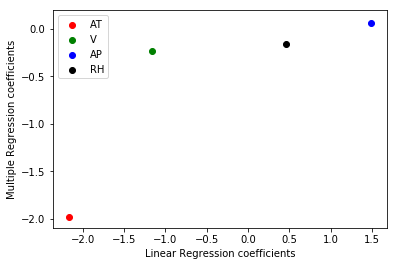

The coefficients for AT,V,AP change in value only in linear regression(with each predictor) and multiple regression but for AP along with the change in value ,the coefficient become negative in multiple regression.This is happening because in Linear Regression(with one predictor) we do not take into account the effect of other predictors but in multiple regression the values of all the predictors come into play which change the coefficients and in turn the predictor's effect 


In [24]:
#1e
comparison_linear_multiple_coefficients(linear_params,multi_params)
print("The coefficients for AT,V,AP change in value only in linear regression(with each predictor) and multiple regression but for AP along with the change in value ,the coefficient become negative in multiple regression.This is happening because in Linear Regression(with one predictor) we do not take into account the effect of other predictors but in multiple regression the values of all the predictors come into play which change the coefficients and in turn the predictor's effect ")

In [25]:
#1f
non_linear_model()
print("In Non-linear model,except for the value for V**2,all others have significant p values.So except V**2,all others show the evidence of non-linear association ")

Non Linear Association for AT
+============+==============+================+=============+=========+=====================================+
|   Names    | Coefficients | Standard Error | t-statistic | p-value |               Results               |
+============+==============+================+=============+=========+=====================================+
| Intercept  |   492.728    |     0.673      |   732.248   |   0.0   | Statistically Significant Parameter |
+------------+--------------+----------------+-------------+---------+-------------------------------------+
| I(AT ** 1) |    -0.61     |     0.124      |   -4.941    |   0.0   | Statistically Significant Parameter |
+------------+--------------+----------------+-------------+---------+-------------------------------------+
| I(AT ** 2) |    -0.125    |     0.007      |   -18.199   |   0.0   | Statistically Significant Parameter |
+------------+--------------+----------------+-------------+---------+----------------------------

In [26]:
#1g
regression_interaction_terms()
print("Those interaction terms for which the results in the above table are statistically significant shows evidence of interaction of predictors with response")

+=======+==============+================+=============+=========+=======================================+
| Names | Coefficients | Standard Error | t-statistic | p-value |                Results                |
+=======+==============+================+=============+=========+=======================================+
| const |   685.782    |     78.64      |    8.721    |   0.0   |                                       |
+-------+--------------+----------------+-------------+---------+---------------------------------------+
|  AT   |    -4.347    |     2.373      |   -1.832    |  0.067  |                                       |
+-------+--------------+----------------+-------------+---------+---------------------------------------+
|   V   |    -7.675    |     1.351      |   -5.682    |   0.0   |                                       |
+-------+--------------+----------------+-------------+---------+---------------------------------------+
|  AP   |    -0.152    |     0.077      |   -1

f:\software\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [27]:
#1h
linear_res=comparison_two_models()

 
FULL MODEL WITH ALL TERMS
+============+==============+================+=============+=========+=======================================+
|   Names    | Coefficients | Standard Error | t-statistic | p-value |                Results                |
+============+==============+================+=============+=========+=======================================+
| Intercept  |  -8223.093   |    1448.338    |   -5.678    |   0.0   |  Statistically Significant Parameter  |
+------------+--------------+----------------+-------------+---------+---------------------------------------+
| I(AT ** 2) |    0.017     |     0.004      |    4.85     |   0.0   |  Statistically Significant Parameter  |
+------------+--------------+----------------+-------------+---------+---------------------------------------+
| I(V ** 2)  |    -0.001    |     0.001      |   -1.112    |  0.266  | Statistically Insignificant Parameter |
+------------+--------------+----------------+-------------+---------+--------------

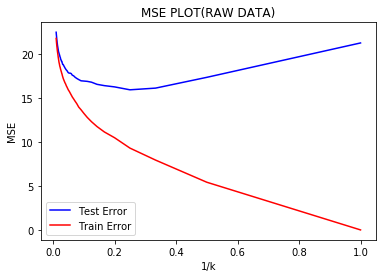

VALUE OF K FOR THE BEST FIT WITH RAW FEAUTURES IS : 4
Smallest Test Error is : 15.93407189785789


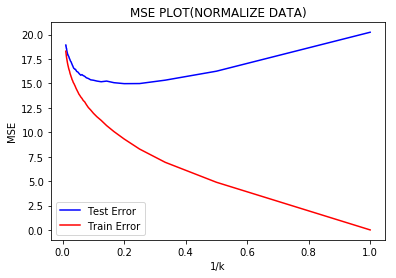

VALUE OF K FOR THE BEST FIT WITH NORMALIZED FEATURES IS : 5
Smallest Test Error is : 14.979033330546855


In [28]:
#1i(i)
knn_raw_res=knn_regression_raw_features()
knn_normalize_res=knn_regression_normalize_features()

In [29]:
#1j
name=["Linear Regression with all terms","Linear regression with significant terms","KNN Regression(Raw Features)","KNN Regression(Normalize Features)"]
headers=["Models","Test Error"]
rowData=[]
results=[linear_res[0],linear_res[1],knn_raw_res,knn_normalize_res]
best_model=results.index(min(results))
rowData.append([name[0],linear_res[0]])
rowData.append([name[1],linear_res[1]])
rowData.append([name[2],knn_raw_res])
rowData.append([name[3],knn_normalize_res])
showData(headers,rowData)

print("As the results of all the four models are nearly equal.They donot have large difference so we cannot really say which model is best.It depends on our requirements and other factors to select the model as linear regression is a parametric approach and KNN Regression is a non-parametric approach")
print("Also, if we have to choose one then, we will go for the model with minimum test error.")
print("The model with minimum test error is : "+str(name[best_model]))

+==========================================+============+
|                  Models                  | Test Error |
+==========================================+============+
|     Linear Regression with all terms     |   17.74    |
+------------------------------------------+------------+
| Linear regression with significant terms |   17.81    |
+------------------------------------------+------------+
|       KNN Regression(Raw Features)       |   15.934   |
+------------------------------------------+------------+
|    KNN Regression(Normalize Features)    |   14.979   |
+------------------------------------------+------------+
As the results of all the four models are nearly equal.They donot have large difference so we cannot really say which model is best.It depends on our requirements and other factors to select the model as linear regression is a parametric approach and KNN Regression is a non-parametric approach
Also, if we have to choose one then, we will go for the model with 

In [30]:
#2(ISLR:2.4.1)
print("ANS 2.4.1 (a): "+"The flexible statistical learning method performs better than an inflexible method as n is large and p is small so the data points will not be scattered much.Therefore, the flexible method will give smoother fit than an inflexible method.")
print()
print("ANS 2.4.1 (b): "+"The flexible statistical learning method performs worse than an inflexible method as n is small and p is large,so due to curse of dimensionality the points will be scattered and a flexible model will try to fit each point which will led to overfitting.")
print()
print("ANS 2.4.1 (c): "+"The flexible statistical learning method performs better than an inflexible method as relationship is highly non -linear and flexible methods works better than inflexible methods(like linear regression which assumes the relationship to be linear) when relationships are non-linear.")
print()
print("ANS 2.4.1 (d): "+"The flexible statistical learning method performs worse than an inflexible method as variance of error terms is extremely high, so the flexible methods will try to fit each data point and which will led to overfitting of data and test error will be high.")

ANS 2.4.1 (a): The flexible statistical learning method performs better than an inflexible method as n is large and p is small so the data points will not be scattered much.Therefore, the flexible method will give smoother fit than an inflexible method.

ANS 2.4.1 (b): The flexible statistical learning method performs worse than an inflexible method as n is small and p is large,so due to curse of dimensionality the points will be scattered and a flexible model will try to fit each point which will led to overfitting.

ANS 2.4.1 (c): The flexible statistical learning method performs better than an inflexible method as relationship is highly non -linear and flexible methods works better than inflexible methods(like linear regression which assumes the relationship to be linear) when relationships are non-linear.

ANS 2.4.1 (d): The flexible statistical learning method performs worse than an inflexible method as variance of error terms is extremely high, so the flexible methods will try to

In [31]:
#3(ISLR:2.4.7)(a)
tr={"X1":[0,2,0,0,-1,1],"X2":[3,0,1,1,0,1],"X3":[0,0,3,2,1,1],"Y":["Red","Red","Red","Green","Green","Red"]}
fg=pd.DataFrame(tr)
test = [0, 0, 0]
for i in range(0,fg.shape[0]):
    dst = distance.euclidean(test, fg.iloc[i,0:3])
    print("Euclidean Distance from "+str(i+1)+" point : "+str(round(dst,2)))

Euclidean Distance from 1 point : 3.0
Euclidean Distance from 2 point : 2.0
Euclidean Distance from 3 point : 3.16
Euclidean Distance from 4 point : 2.24
Euclidean Distance from 5 point : 1.41
Euclidean Distance from 6 point : 1.73


In [32]:
#3(ISLR:2.4.7)(b)
res=knn_classifier(1)
print("Result for k=1 is : "+ str(res))
print("For k=1,the nearest neighbor to the test point has label "+str(res)+"."+"That's why the label for test data is : "+str(res))

Result for k=1 is : Green
For k=1,the nearest neighbor to the test point has label Green.That's why the label for test data is : Green


In [33]:
#3(ISLR:2.4.7)(c)
res=knn_classifier(3)
print("Result for k=3 is : "+ str(res))
print("For k=3,among 3 nearest neighbors to the test point 2 has label "+str(res)+"."+"That's why the label for test data is : "+str(res))

Result for k=3 is : Red
For k=3,among 3 nearest neighbors to the test point 2 has label Red.That's why the label for test data is : Red


In [34]:
#3(ISLR:2.4.7)(d)
print("When the Bayesian decision boundary is highly non-linear, we will expect the best value of k to be small as when k is small,the decision boundary will be overly flexible as less data points will come in KNN which makes the boundary non linear.")

When the Bayesian decision boundary is highly non-linear, we will expect the best value of k to be small as when k is small,the decision boundary will be overly flexible as less data points will come in KNN which makes the boundary non linear.
